# Robust Homography Estimation

Your name: Said Abdalrahim

Your ID number: 24177075

We've seen that the DLT is not robust against outliers, which is dissappointing. In the real world, we cannot guarantee always that we will alway get inliers in feature matching algorithms. That's where robust estimation via RANSAC comes in. RANSAC is a powerful, but ultimately quite straightforward algorithm to implement.

Let's start by reading the two images, like we did last time.

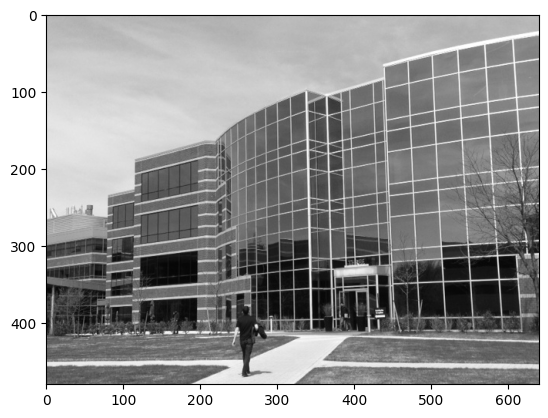

In [107]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imgL = cv2.imread('building1.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(imgL,cmap='gray')

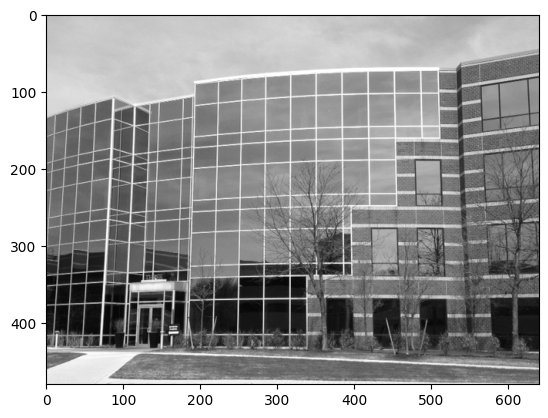

In [108]:
imgR = cv2.imread('building2.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(imgR,cmap='gray');

Again, I will give you the feature matching.

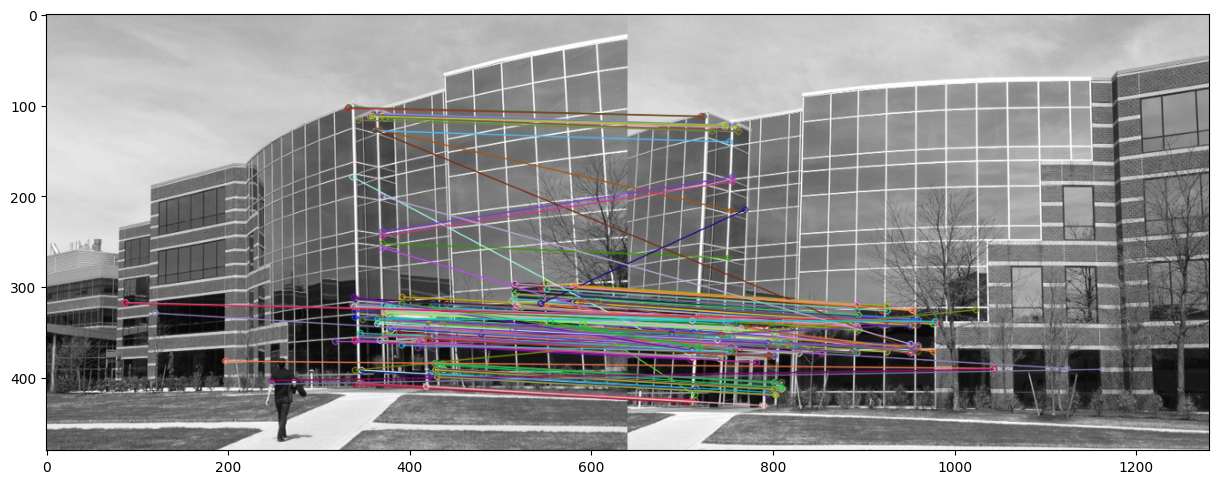

In [109]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(imgL,None)
kp2, des2 = orb.detectAndCompute(imgR,None)
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 120 matches.
img3 = cv2.drawMatches(imgL,kp1,imgR,kp2,matches[:200],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (15,15)),plt.imshow(img3),plt.show();

As we noticed before, there are a few outliers that we dislike, as we saw they really messed up the DLT. Let's look at how to handle these.

In [110]:
# Extract 200 features, outliers and all
n_features = 200
left_pts = np.float32([kp1[m.queryIdx].pt for m in matches[:200]]).reshape(-1,2)
rght_pts = np.float32([kp2[m.trainIdx].pt for m in matches[:200]]).reshape(-1,2)

Recall from the lectures that this is the RANSAC algorithm for estimating the homography:
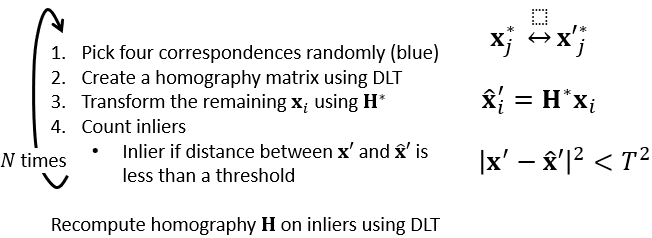

<font color='blue'>

#### Task:
    
Create a robust panorama generator from the two photos, based on the RANSAC algorithm. Soem helpful hints are given in the code below.


a utility function for creating the homography transform to reuse later

In [111]:
def get_homography_transform(left_points, right_points, number_of_matches=4):
    """
    Computes the homography matrix using the Direct Linear Transformation (DLT) algorithm.

    Parameters:
    left_points (numpy.ndarray): Array of points from the left image. Shape should be (number_of_matches, 2).
    right_points (numpy.ndarray): Array of points from the right image. Shape should be (number_of_matches, 2).
    number_of_matches (int): Number of point correspondences to use for computing the homography. Default is 4.

    Returns:
    numpy.ndarray: The 3x3 homography matrix.
    """
    B = []
    for i in range(number_of_matches):
        x, y = left_points[i]             
        x_prime, y_prime = right_points[i] 
        
        B.append([-x, -y, -1, 0, 0, 0, x * x_prime, y * x_prime, x_prime])
        B.append([0, 0, 0, -x, -y, -1, x * y_prime, y * y_prime, y_prime])

    # SVD
    U, S, Vt = np.linalg.svd(B, full_matrices=True)

    # get the params and reshape the Vt to a 3x3 matrix
    h = Vt[-1].reshape(3,3)

    # rescale to make h33 = 1
    h = h/h[2,2]

    return h

here I went with the lowest amount of iterations that gave a pretty accurate image for efficiency, 10 gave slight distortion, but 20 seemed to do the job

just initializations of variables here

In [112]:
np.random.seed(42)

n_ransac_iters = 20

# These are the variables that the RANSAC iterations should populate
# The number of inliers that the best RANSAC iteration gives
n_inliers_best = 0
# The best homography matrix, based on the number of inliers
best_H = []

# We also need to keep the subset of feature locations that are counted as inliers.
# As mentioned above, we want to do a final DLT on all of the inliers
inliersL = []
inliersR = []

# We also need a threshold for our inliers
thresh = 5
# number of points we are looking for in the ransac algorithm
number_of_matches = 4

In [113]:
# This just means that the randomness is repeatible

# The RANSAC iterations
for i in range(0,n_ransac_iters):
    # get four random points
    idx = np.random.randint(0, len(left_pts), number_of_matches)
    p1 = left_pts[idx]
    p2 = rght_pts[idx]
    
    # get the homography matrix
    h = get_homography_transform(p1, p2, number_of_matches)

    # convert to homogeneous form
    left_pts_h = np.hstack((left_pts, np.ones((len(left_pts),1))))
    rght_pts_h = np.hstack((rght_pts, np.ones((len(rght_pts),1))))

    # calculate the transformed points
    left_pts_h_transformed = np.dot(h, left_pts_h.T).T
    left_pts_h_transformed /= left_pts_h_transformed[:,2].reshape(-1,1)

    # denormalize the points
    left_pts_h_transformed = left_pts_h_transformed[:,0:2]
    # calculate the distance between the transformed points and the right points
    dist = np.linalg.norm(left_pts_h_transformed - rght_pts_h[:,0:2], axis=1)
    
    # check that the distance is less than the threshold
    inliers = np.where(dist*dist < thresh*thresh)[0]
    n_inliers = len(inliers)
    # 4. Is this the best so far? If it is, store the information here
    if n_inliers > n_inliers_best:
        inliersL = left_pts[inliers]
        inliersR = rght_pts[inliers]
        n_inliers_best = n_inliers


In [114]:
# 5. Once the RANSAC loop exits, run the DLT algorithm again on all of the inliers. Again,
# this is very similar to what you did in the last task, just using the RANSAC inliers not
# all of the features.

# Use the get_homography_transform function to get the homography matrix for inliers
h = get_homography_transform(inliersL, inliersR, len(inliersL))

# Compute the inverse of the homography matrix
h_inv = np.linalg.inv(h)

At the end of the RANSAC, you should have a robust estimate of the homography matrix, which handles outliers in a way that the DLT simply wasn't able to.

<font color='blue'>

#### Task:
Warp the right image to match the left image, and create your two-image panorama again. code snippet below. Only a small piece of code to add here.
    
Don't forget, we are warping the right image tot match the left, so we use the homography inverse.

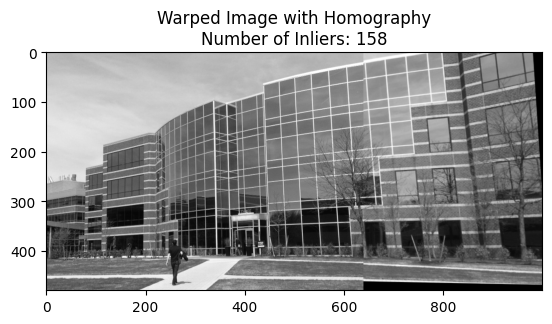

In [115]:
##################
# Your code here

plt.title(f'Warped Image with Homography\nNumber of Inliers: {len(inliersL)}')
imgW = cv2.warpPerspective(imgR, h_inv,(1000,imgL.shape[0])) # replace the 3 dots with your code

# This piece puts the left image in the output image at the requisite place
imgW[:,:imgL.shape[1]] = imgL

plt.imshow(imgW,cmap='gray')